In [1]:
import numpy as np
from girder import GirderSection
from opensees import section, patch
import opensees.render.mpl as render
from opensees.units.english import inch, foot

```
     ^ y
     |   104'    |    104'   |
   _____________________________
   ##o___________o___________o### __
   ##\          | |         /####  | 17'
   z .\_________|o|________/#####------> x

```

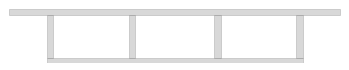

In [2]:
sect = GirderSection(
    thickness_top  = (7 + 1/3)  * inch,
    thickness_bot  = (6 + 1/8)  * inch,
    height         =     5.5    * foot,
    width_top      =    2*17    * foot,
    width_webs     = ([8.0]*4)  * inch,
    web_spacing    = 8*foot + 9*inch,
    overhang       = 3*foot + 10.5*inch
    # web_slope = 0.5
)
render.section(sect, set_limits=True);#, fix_axes=False);

In [3]:
Lg    =         104*foot
Jg    = 2000000000
# Jg    = 364_445_475
# Jg    =           np.nan
Ag    =   sect.area*inch**2
# Igx   =   4_074_000*inch**4
# Igy   =  79_510_000*inch**4
Igx = sect.ixc
Igy = sect.iyc
ygc = sect.centroid[1]

Lc   =    17*foot + ygc + + 6.125/2*inch
Ic   =   10_178_760*inch**4
# Jc   =   20_357_520*inch**4
Jc    = 2000000000
Ac   =       11_310*inch**2

E    =    4_074_000  # psi
G    =    1_698_000

### $K$ Matrix

In [4]:
K  =  np.empty((6,6)) * np.nan

# Longitudinal translation
K[0,0] = 2*E*Ag/Lg + 12*E*Ic/Lc**3
K[0,1] = K[1,0] = 0.0
K[0,2] = K[2,0] = 0.0
K[0,3] = K[3,0] = 0.0
K[0,4] = K[4,0] = 0.0
K[0,5] = K[5,0] = 6*E*Ic/Lc**2

# Vertical translation
K[1,1] = E*Ac/Lc + 24*E*Igx/Lg**3
K[1,2] = K[2,1] = 0.0
K[1,3] = K[3,1] = 0.0
K[1,4] = K[4,1] = 0.0
K[1,5] = K[5,1] = 0.0

# Transverse translation
K[2,2] = 12*E*Ic/Lc**3 + 24*E*Igy/Lg**3
K[2,3] = K[3,2] = -6*E*Ic/Lc**2
K[2,4] = K[4,2] = 0.0
K[2,5] = K[5,2] = 0.0

# Section rotation
K[3,3] = 2*G*Jg/Lg + 4*E*Ic/Lc
K[3,4] = K[4,3] = 0.0
K[3,5] = K[5,3] = 0.0

# Plan rotation
K[4,4] = G*Jc/Lc + 2*4*E*Igy/Lg
K[4,5] = K[5,4] = 0.0

# Elevation rotation
K[5,5] = 4*E*Ic/Lc + 2*4*E*Igx/Lg

In [5]:
import pandas as pd
pd.DataFrame(K)

,0,1,2,3,4,5
0,7.717329e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.163673e+09
1,0.000000e+00,1.887206e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,3.806892e+07,-4.163673e+09,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,-4.163673e+09,6.120856e+12,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.597084e+13,0.000000e+00
5,4.163673e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.982410e+11


In [6]:
Pf = np.zeros(6)
Pf[2] = 1.0
pd.DataFrame(np.linalg.solve(K, Pf))

,0
0,0.000000e+00
1,0.000000e+00
2,2.837957e-08
3,1.930502e-11
4,0.000000e+00
5,-0.000000e+00


## Model

In [7]:
from meloland import meloland

In [8]:
model = meloland(sect, section.FiberSection(
    areas=[patch.circ(extRad=5.0*foot)]))

In [9]:
import opensees.emit
# script = opensees.emit.FEDEAS_Writer(model.apply({})).dump()
script = opensees.emit.OpenSeesWriter(model.apply({})).dump()
# print(script)

In [10]:
import opensees.tcl
builder = opensees.tcl.BasicBuilder(ndm=3, ndf=6)
builder.eval(script)

'12 13 14 15 16 17 '

In [11]:
builder.eval("printA -file A.txt")

''

## Analysis

In [ ]:
def u_sin(t, omega, M):
    pass